In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize as imresize

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

In [ ]:
model_file = "C:\Users\nicol\Code\DeepFruit\src\retrain\model_fruitdb\output_graph.pb"
label_file = "C:\Users\nicol\Code\DeepFruit\src\retrain\model_fruitdb\output_labels.txt"
image_file = "C:\Users\nicol\Code\DeepFruit\Fruit_Database\Apple.png"
input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = "Placeholder"
output_layer = "final_result"


In [ ]:
graph = load_graph(model_file)

images_dir = "C:\Users\nicol\Code\DeepFruit\Fruit_Database"
images_t = []
for i, folder in enumerate(os.listdir(images_dir)):
    # Select the first image in each folder
    first_image = (os.listdir(os.path.join(images_dir, folder)))[0]
    # Read image
    img = os.path.join(images_dir,folder + '/' + first_image)
    
    t = read_tensor_from_image_file(
        img,
        input_height=input_height,
        input_width=input_width,
        input_mean=input_mean,
        input_std=input_std)
    images_t.append(t)


In [5]:
input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

/home/jeeza/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


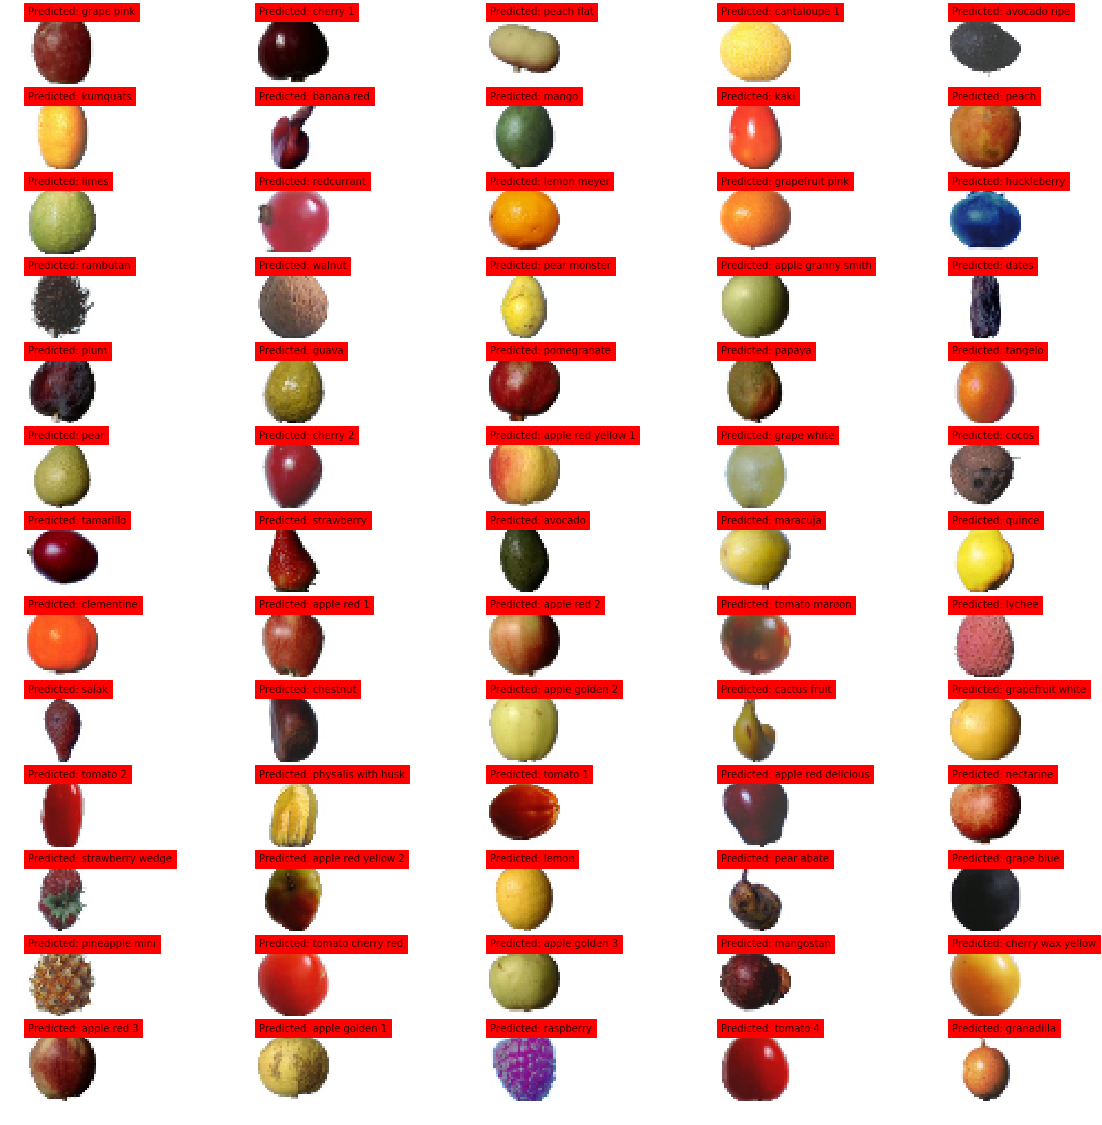

In [6]:
results = []
with tf.Session(graph=graph) as sess:
    for t in images_t:
        result = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
        results.append(np.squeeze(result)) 

labels = []
for result in results:
    top_k = result.argsort()[-5:][::-1]
    _labels = load_labels(label_file)
    labels.append(_labels[top_k[0]])

    
images = np.empty([90,32,32,3])

for i, folder in enumerate(os.listdir(images_dir)):
    # Select the first image in each folder
    first_image = (os.listdir(os.path.join(images_dir, folder)))[0]
    # Read image
    img = plt.imread(os.path.join(images_dir,folder + '/' + first_image))
    # Resize and store image
    images[i,:,:,:] = imresize(img, (32, 32, 3), mode = 'constant')
    
# creating 90 subplots with 18 rows and 5 columns
figure, ax = plt.subplots(13,5,figsize = (20, 20))

# initializing count variable i

i = 0

# looping over subplot rows
for k in range(13):
    # looping over subplot columns
    for j in range(5):
        # plotting image
        ax[k,j].text(0, 0, 'Predicted: %s' % labels[i], color='k', backgroundcolor='red', alpha=0.8)
        ax[k,j].imshow(images[i])

        #turning axis off
        ax[k,j].axis('off')
        
        # updating count variable
        i += 1